<a href="https://colab.research.google.com/github/reza-pishva/RNN-projects/blob/main/main_trans_oil_temp_with_covariates_winding_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import rmse, mae
import matplotlib.pyplot as plt

In [4]:
df = pd.read_excel("main_trans.xlsx")
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime'])

In [5]:
target_date = pd.to_datetime('1/13/2023  00:00:00 AM')
df_filtered = df[(df['DateTime'] >= target_date)]

In [6]:
df = df.set_index('DateTime')
df_resampled = df.resample('1H').mean()

/tmp/ipython-input-639737280.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('1H').mean()


In [7]:
df_resampled = df_resampled.interpolate(method='linear')

In [8]:
series = TimeSeries.from_dataframe(df_resampled, value_cols='oil temperature', freq='h')
covariates = TimeSeries.from_dataframe(df_resampled, value_cols=['winding temperature'], freq='h')

In [9]:
scaler_series = Scaler(MinMaxScaler())
series_scaled = scaler_series.fit_transform(series)

In [10]:
scaler_cov = Scaler(MinMaxScaler())
covariates_scaled = scaler_cov.fit_transform(covariates)

In [11]:
train_ratio = 0.95
train_series, test_series = series_scaled.split_after(train_ratio)
train_cov, test_cov = covariates_scaled.split_after(train_ratio)

In [12]:
model = BlockRNNModel(
    model='LSTM',
    input_chunk_length=48,
    output_chunk_length=12,
    hidden_dim=32,
    n_rnn_layers=3,
    dropout=0.2,
    n_epochs=40,
    random_state=42
)

In [13]:
# model.fit(train_series)
model.fit(series=train_series, past_covariates=train_cov, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 21.5 K | train
6 | fc              | Sequential       | 33     | train
-------------------------------------------------------------
21.5 K    Trainable params
0         Non-trainable p

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=32, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.2, activation=ReLU, use_static_covariates=True, input_chunk_length=48, output_chunk_length=12, n_epochs=40, random_state=42)

In [14]:
pred = model.predict(n=len(test_series), series=train_series, past_covariates=covariates_scaled)
# pred = model.predict(n=len(test_series))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [15]:
pred = scaler_series.inverse_transform(pred)
test_series = scaler_series.inverse_transform(test_series)

In [16]:
print(f"RMSE: {rmse(test_series, pred):.2f}")
print(f"MAE: {mae(test_series, pred):.2f}")

RMSE: 2.42
MAE: 1.92


In [17]:
df_test = pd.DataFrame({
    'oil temperature': test_series.values().flatten()
}, index=test_series.time_index)

df_pred = pd.DataFrame({
    'oil temperature': pred.values().flatten()
}, index=pred.time_index)




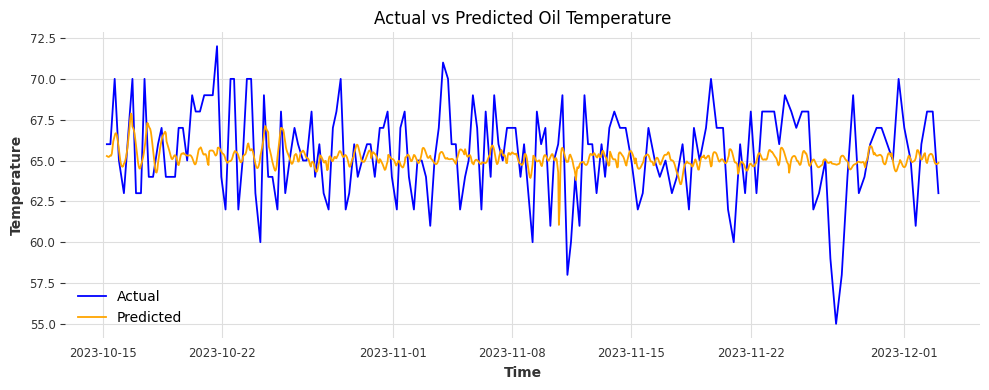

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(df_test.index, df_test['oil temperature'], label='Actual', color='blue')
plt.plot(df_pred.index, df_pred['oil temperature'], label='Predicted', color='orange')
plt.legend()
plt.title("Actual vs Predicted Oil Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# !pip install darts

In [20]:
# 🔍 اجرای 3 با پارامترها: {'input_chunk_length': 36, 'output_chunk_length': 12, 'hidden_dim': 64, 'dropout': 0.2}
# 📉 RMSE: 2.53 | MAE: 1.94